In [240]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sn
import matplotlib.pyplot as plt
import itertools
import math

# Week 4 Peer Review Project
## BBC Text Classification through Matrix Factorization
### Ethan Tucker, 6/17/2022

Please adapt this following line to set your working directory such that it has a child directory named "data" containing the data used in this project.

In [241]:
%cd "C:/Users/first/Desktop/DTSA_5510_HW/Week_4_HW/BBC_Text_Classification"

C:\Users\first\Desktop\DTSA_5510_HW\Week_4_HW\BBC_Text_Classification


In [242]:
os.listdir("./data")

['BBC News Sample Solution.csv', 'BBC News Test.csv', 'BBC News Train.csv']

# Step 1: Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

I will first load the test and training datasets into jupyter, clean the datasets, and then do an EDA on the training data. I will use TF-IDF to extract the texts as features. I follow the process listed at [freecodecamp](https://www.freecodecamp.org/news/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3/), and supported by a glob post on [medium](https://medium.com/@imamun/creating-a-tf-idf-in-python-e43f05e4d424). I will keep the data as pandas DataFrames until model building because the datasets are sufficiently small for the loss in time efficiency to be negligible. The models in Step 2 will be built on the test data, because they do not have labels and this is supposed to be an unsupervised learning project. The training data is very convenient for EDA because it does have labels, so we can get some inkling of the trends that Matrix Factorization may pick up. Here is the procedure I will follow for EDA:

1) Inspect attribute classes, counts, null values

2) Determine number of categories desired by inspecting unique values of Category in train data

3) Make a bar chart for Category over the train data to show distribution of unique values. Do the same with test data. Show TFIDF weights Vs. word.

## Initial Inspections

Below I load the test and train data into jupyter, then call info() and head() on the dataframes. The Non-Null count shows that there are no null categories, articles, nor articleID's to clean. The train dataset has 1490 articles, and the test dataset has 735 articles. The datasets are both small in size, with the train data taking approximately 35 KB, and the test data taking about 11.6 KB. The data are perfectly rectangular, so the main cleaning task is to use TF-IDF to construct weights for each word. These weights will be stored in a matrix, which when factored will yield the predicted categories.

In [243]:
#Load traindf and testdf
traindf = pd.read_csv("./data/BBC News Train.csv")
testdf = pd.read_csv("./data/BBC News Test.csv")

#Perform an initial inspection of traindf
print(traindf.info())
traindf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


The categories of article present in the training data are: ['business' 'tech' 'politics' 'sport' 'entertainment']


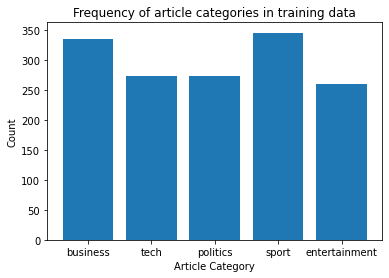

In [244]:
# Print the unique categories present in the training dataset, and make a bar plot of their relative frequencies
print("The categories of article present in the training data are:", traindf.iloc[:, 2].unique())

# Draw a histogram of the frequencies of categories in the training data.
counts = list(traindf.groupby("Category").count().iloc[:, 0])
Categories = list(traindf.iloc[:, 2].unique())

plt.bar(Categories, counts)
plt.xlabel("Article Category")
plt.ylabel("Count")
plt.title("Frequency of article categories in training data")
plt.show()

In [245]:
# This cell does an initial inspection of testdf
print(testdf.info())
testdf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


## Feature Extraction with TF-IDF

TF-IDF stands for term frequency - inverse data frequency. TF-IDF constructs a skewed matrix, which then can be normalized into a form that is convenient to factor. Fortunately sklearn takes care of this normalization for us. In TF-IDF each word is given a weight which balances it's frequency with its rarity, the underlying idea being that globally rare words are useful as categorical identifiers, and the more frequent such "buzzwords" are used the more clear indication of a category it is. Here's the math:

The frequency of a term in a document (i.e. a word or phrase, but in our implementation it will just be a word due to processing time concerns) is calculated as:

$$TF(i, j) = \frac{\text{Frequency of term i in document j}}{\text{Total word count of document j}}$$

The inverse document frequency of a term over all documents is calculated as:

$$IDF(i) = \log_2{\frac{\text{Total number of documents}}{\text{Number of documents with term i}}}$$

By multiplying these quantities, we obtain weights for word "usefulness" in identifying categories. We can run this over all articles in a desired dataframe (either test or train) to construct a matrix of dimension (number of documents, number of unique terms). 

Citation: [Medium article](https://medium.com/@imamun/creating-a-tf-idf-in-python-e43f05e4d424)



In [246]:
# Feature extraction on training data
traincorpus = list(traindf["Text"])
trainvector = TfidfVectorizer()
trainresponse = trainvector.fit_transform(traincorpus).todense()
print("The resulting matrix for the training data has shape:", trainresponse.shape)

# Feature extraction on test data
testcorpus = list(testdf["Text"])
testvector = TfidfVectorizer()
testresponse = testvector.fit_transform(testcorpus).todense()
print("The resulting matrix for the test data has shape:", testresponse.shape)

The resulting matrix for the training data has shape: (1490, 24746)
The resulting matrix for the test data has shape: (735, 18460)


## Some Word Count Visualizations

Now that the features are extracted, we can do some EDA. The most interesting plot I can think to make is Word Vs. TF-IDF for the highest weighted words. That is to say, I will make a bar plot showing some of the words that most strongly indicate specific categories. 

Note: The fifty highest weighted words include a bunch of unsuccessfully filtered common words such as "their", "to", "mr", and "and". As such I will actually be plotting the fifty first through eightieth highest weighted words by TFIDF, because they are much more interesting and domain specific.

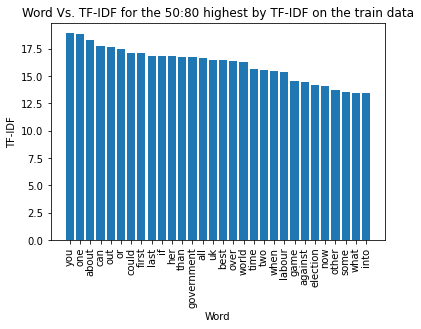

In [247]:
# Store words and column sums as np.ndarray(s)
trainFeatureNames = np.asarray(trainvector.get_feature_names()).reshape(1, trainresponse.shape[1])
trainFeatureTFIDF = np.asarray(trainresponse.sum(axis = 0))
trainIndex = np.argsort(trainFeatureTFIDF)

#Plot highest leverage words
n_to_plot = 30
trainPlotNames = trainFeatureNames[:, trainIndex[0, ::-1]][:, 50 : 50 + n_to_plot].tolist()[0]
trainPlotTFIDF = trainFeatureTFIDF[:, trainIndex[0, ::-1]][:, 50 : 50 + n_to_plot].tolist()[0]

plt.bar(trainPlotNames, trainPlotTFIDF)
plt.xlabel("Word")
plt.ylabel("TF-IDF")
plt.title("Word Vs. TF-IDF for the 50:80 highest by TF-IDF on the train data")
plt.xticks(rotation=90)
plt.show()

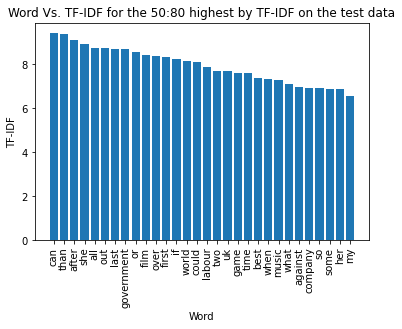

In [248]:
# Store words and column sums as np.ndarray(s)
testFeatureNames = np.asarray(testvector.get_feature_names()).reshape(1, testresponse.shape[1])
testFeatureTFIDF = np.asarray(testresponse.sum(axis = 0))
testIndex = np.argsort(testFeatureTFIDF)

#Plot highest leverage words
n_to_plot = 30
testPlotNames = testFeatureNames[:, testIndex[0, ::-1]][:, 50 : 50 + n_to_plot].tolist()[0]
testPlotTFIDF = testFeatureTFIDF[:, testIndex[0, ::-1]][:, 50 : 50 + n_to_plot].tolist()[0]

plt.bar(testPlotNames, testPlotTFIDF)
plt.xlabel("Word")
plt.ylabel("TF-IDF")
plt.title("Word Vs. TF-IDF for the 50:80 highest by TF-IDF on the test data")
plt.xticks(rotation=90)
plt.show()

# Step 2: Building and training models. [35 pts]

1) *Think about this and answer: when you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?*

In week one we learned that the overall goal of unsupervised learning is to uncover hidden trends in data, not to accurately predict a label. We are more interested in clustering similar things together rather than deciding what those things are. In the test and train data provided we have the advantage of knowing that there are exactly five categories to predict. In supervised learning, we would use only the training data to prevent overfitting on the test set. In unsupervised learning however, we do not assume any labels in the first place. As such, there is really no distinction between the test and train sets. There is further no risk of overfitting, because there is no feedback that occurs when labels are predicted. We can therefore train the model on both sets, then predict categories for each individually using the full model.

2) *Build a model using the matrix factorization method(s) and predict the train and test data labels. Choose any hyperparameter (e.g., number of word features) to begin with.*

I will reconstruct my models by smashing the test and train data together, then repeating the TF-IDF process. I will use non-negative matrix factorization, which works well because TF-IDF values are automatically non-negative. As an illustration of this: The minimum value for TF is 0, and the minimum value for IDF is $\log_2{1} = 0$. Therefore the overall minimum value of the product between TF and IDF is also zero. According to [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html), the parameter init = "nndsvd" provides a better performance for sparse matricies. Our matrix is extremely sparse, so this is a good idea. In addition, the most common entry of the matrix by far is 0. As such I have a strong suspiscion that KL-loss will yield the best performance. KL-loss doesn't play well with "nndsvd" though, so I'll start with L2-loss then loop back to KL-loss later.

#### L2-Loss:

In [249]:
# Concatenate "Text" attribute of training and test data sets into one corpus. Then build a TF-IDF matrix from the corpus.
corpus = pd.concat([traindf["Text"], testdf["Text"]], copy = True, ignore_index = True).tolist()
vector = TfidfVectorizer()
response = vector.fit_transform(corpus)
print("The resulting matrix for all data has shape:", response.shape)

The resulting matrix for all data has shape: (2225, 29421)


In [250]:
# Build NMF model with initial parameter selections
firstModel = NMF(n_components = 5, random_state = 42, init = 'nndsvd', beta_loss = "frobenius", max_iter= 1000)
W = firstModel.fit_transform(response)
H = firstModel.components_

In [251]:
# Get some info about the output matricies. W holds the transformed data, H holds the finalized weights for each word.
print(type(W))
print(type(H))
print(W.shape, H.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(2225, 5) (5, 29421)


### Commentary:

The fit_transform() method yields the transformed dataset with cluster weights. Below I print out the first predicted cluster weights. The maximum weight is 0.049 for cluster 1, and so we predict that article one belongs to cluster 1. Row 0 corresponds to article 0 from the training data by the order of concatenation I used. We therefore predict that article 0 from the training data belongs to cluster 1, whatever that might be. It is important to note that this prediction may be a misclassification, so we cannot just use the label "business" for category 1, which is the true label for article 0. I will construct a maximum likelihood estimator that collects the predictions over all texts, then decides what the labels are using the best subset algorithm. This is reasonable because there are only $120$ possible permutations of five distinct categories. I will only use the labelled training data for the MLE for obvious reasons.

In [252]:
# Illustrate cluster prediction for article 0
print(W[0, :])
traindf.iloc[0, :]

[0.03765192 0.0491437  0.00705333 0.00357724 0.        ]


ArticleId                                                 1833
Text         worldcom ex-boss launches defence lawyers defe...
Category                                              business
Name: 0, dtype: object

In [253]:
# Turn matrix W into array of predictions
def FinalizePredictions(W):
    """
        input: numpy.ndarray W (output of NMF.fit_transform())
        output: numpy.ndarray predictions
    """
    predictions = np.zeros(shape = (W.shape[0]))
    n_rows = W.shape[0]
    n_cols = W.shape[1]
    
    for i in range(n_rows):
        current_best = (None, 0) # current_best is of form (column number, highest weight)
        for j in range(n_cols):
            if W[i, j] > current_best[1]:
                current_best = (j, W[i, j])
        
        if current_best[0] == None:
            print("Something bad happened")
            
        predictions[i] = current_best[0]
    
    return(predictions)

# Construct category namer function based on MLE
def MakeCategoryNames(df, pred):
    """
        input: pandas.DataFrame df (must have labels in column 2)
        input: numpy.ndarray pred (output of FinalizePredictions())
        output: dictionary of form {column index : "Category Name"}
    """
    #Our approach will be to minimize the total error count over all labellings.
    trainnumpy = df.to_numpy()
    n_train = trainnumpy.shape[0]
    labels = trainnumpy[:, 2]
    categories = list(np.unique(labels))
    permutations = list(itertools.permutations(categories))
    
    currentBest = (None, float("inf"))
    
    for subset in permutations:
        n_misclassified = 0
        for i in range(n_train):
            if subset[int(pred[i])] != labels[i]:
                n_misclassified = n_misclassified + 1
        if n_misclassified < currentBest[1]:
            currentBest = (subset, n_misclassified)
    
    return(currentBest)

yhat = FinalizePredictions(W)
CategoryNames = MakeCategoryNames(traindf, yhat)

print("The best permutation of labels was:", CategoryNames[0], "which resulted in a total of", CategoryNames[1], "total misclassifications on the training data.")

The best permutation of labels was: ('business', 'politics', 'sport', 'tech', 'entertainment') which resulted in a total of 176 total misclassifications on the training data.


3) *Measure the performances on predictions from both train and test datasets. You can use accuracy, confusion matrix, etc., to inspect the performance. You can get accuracy for the test data by submitting the result to Kaggle.*

The MLE function I wrote can be used to measure accuracy, but not precision, recall, or any other nice model metric that we may wish to use. As such I will convert the true labels from strings to category numbers, then feed the predictions and labels for the training data into sklearn.metrics. I will submit my results to kaggle to obtain an accuracy reading on the test set.

In [254]:
#Convert labels into integer np.ndarray
labs = list(traindf["Category"])
newlabs = list()
labelDictionary = {
    CategoryNames[0][0] : 0,
    CategoryNames[0][1] : 1,
    CategoryNames[0][2] : 2,
    CategoryNames[0][3] : 3, 
    CategoryNames[0][4] : 4
}
for label in labs:
    this_newlab = labelDictionary[label]
    newlabs.append(this_newlab)
newlabs = np.asarray(newlabs)

In [255]:
# Construct confusion matrix and model metrics for training data
first_confusion_matrix = confusion_matrix(y_true = newlabs, y_pred = yhat[:newlabs.shape[0]])
first_accuracy = accuracy_score(y_true = newlabs, y_pred = yhat[:newlabs.shape[0]])
first_recall = recall_score(y_true = newlabs, y_pred = yhat[:newlabs.shape[0]], average = None)
first_precision = precision_score(y_true = newlabs, y_pred = yhat[:newlabs.shape[0]], average = None)
print(first_confusion_matrix)
print("On the training data, our initial model had accuracy =", first_accuracy, ". Recall and precision for multiclass variables must be calculated by category. Where the categories were:", CategoryNames[0], "the model returned recall =", first_recall, "; and precision =", first_precision) 

[[297  16   3  19   1]
 [ 15 219   4  36   0]
 [  2   0 342   0   2]
 [  5   1   2 250   3]
 [  7   5  19  36 206]]
On the training data, our initial model had accuracy = 0.8818791946308725 . Recall and precision for multiclass variables must be calculated by category. Where the categories were: ('business', 'politics', 'sport', 'tech', 'entertainment') the model returned recall = [0.88392857 0.79927007 0.98843931 0.95785441 0.75457875] ; and precision = [0.91104294 0.90871369 0.92432432 0.73313783 0.97169811]


In [256]:
print(first_precision.mean())
print(first_recall.mean())

0.889783381035046
0.8768142222977353


In [257]:
# Construct csv with test set predictions to export to kaggle
testpred = yhat[newlabs.shape[0]:].astype(int) #Citation https://www.datasciencelearner.com/convert-numpy-float-to-int/
makeNames = {
    0 : CategoryNames[0][0],
    1 : CategoryNames[0][1],
    2 : CategoryNames[0][2],
    3 : CategoryNames[0][3], 
    4 : CategoryNames[0][4] 
}
newpred = list()
for pred in testpred:
    this_category = makeNames[pred]
    newpred.append(this_category)
    
testDic = {
    "ArticleId" : list(testdf["ArticleId"]),
    "Category" : newpred
}

first_testSolutiondf = pd.DataFrame(testDic)
first_testSolutiondf.to_csv("./testSolutions1.csv")

### Commentary:

The first model had a reasonably good accuracy at 0.8818 on the training set, and the following accuracy on the test set:

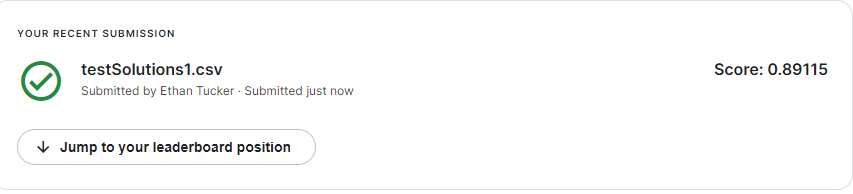

On the training data, the model had much better precision than recall in most of the five categories, indicating that we should expect more false positives than false negatives. 

I will do sections (4) and (5) together, because adjusting hyperparams will influence the results.

4) *Change hyperparameter(s) and record the results. We recommend including a summary table and/or graphs.*

5) *Improve the model performance if you can- some ideas may include but are not limited to; using different feature extraction methods, fit models in different subsets of data, ensemble the model prediction results, etc.*

To determine if we can do better, we will alter hyperparameters in the NMF solver and repeat. I want to use KL-loss for comparison, because in class we discussed that KL-loss was good for matricies overpopulated with zeroes. I'll also try IS-Loss for completeness.

#### KL-Loss:

In [258]:
# Make second model using KL-Loss
secondModel = NMF(n_components = 5, random_state = 42, init = 'nndsvda', solver = "mu", beta_loss = "kullback-leibler", max_iter= 1000)
W = secondModel.fit_transform(response)
H = secondModel.components_

In [259]:
yhat = FinalizePredictions(W)
CategoryNames = MakeCategoryNames(traindf, yhat)

print("The best permutation of labels was:", CategoryNames[0], "which resulted in a total of", CategoryNames[1], "total misclassifications on the training data.")

The best permutation of labels was: ('business', 'politics', 'sport', 'tech', 'entertainment') which resulted in a total of 72 total misclassifications on the training data.


In [260]:
# Construct confusion matrix and model metrics for training data
second_confusion_matrix = confusion_matrix(y_true = newlabs, y_pred = yhat[:newlabs.shape[0]])
second_accuracy = accuracy_score(y_true = newlabs, y_pred = yhat[:newlabs.shape[0]])
second_recall = recall_score(y_true = newlabs, y_pred = yhat[:newlabs.shape[0]], average = None)
second_precision = precision_score(y_true = newlabs, y_pred = yhat[:newlabs.shape[0]], average = None)
print(second_confusion_matrix)
print("On the training data, our second model had accuracy =", second_accuracy, ". Recall and precision for multiclass variables must be calculated by category. Where the categories were:", CategoryNames[0], "the model returned recall =", second_recall, "; and precision =", second_precision) 

[[320   8   0   8   0]
 [ 17 252   0   2   3]
 [  1   0 344   0   1]
 [  9   3   0 242   7]
 [  7   2   1   3 260]]
On the training data, our second model had accuracy = 0.9516778523489933 . Recall and precision for multiclass variables must be calculated by category. Where the categories were: ('business', 'politics', 'sport', 'tech', 'entertainment') the model returned recall = [0.95238095 0.91970803 0.99421965 0.92720307 0.95238095] ; and precision = [0.9039548  0.9509434  0.99710145 0.94901961 0.95940959]


In [261]:
print(second_precision.mean())
print(second_recall.mean())

0.9520857699401486
0.9491785304544551


In [262]:
# Construct csv with test set predictions to export to kaggle
testpred = yhat[newlabs.shape[0]:].astype(int) #Citation https://www.datasciencelearner.com/convert-numpy-float-to-int/
makeNames = {
    0 : CategoryNames[0][0],
    1 : CategoryNames[0][1],
    2 : CategoryNames[0][2],
    3 : CategoryNames[0][3], 
    4 : CategoryNames[0][4] 
}
newpred = list()
for pred in testpred:
    this_category = makeNames[pred]
    newpred.append(this_category)
    
testDic = {
    "ArticleId" : list(testdf["ArticleId"]),
    "Category" : newpred
}

second_testSolutiondf = pd.DataFrame(testDic)
second_testSolutiondf.to_csv("./testSolutions2.csv")

### Commentary:

The KL-Loss NMF was much better! The accuracy, average recall, and average precision all went up drastically on the training set. The test set performance also increased:

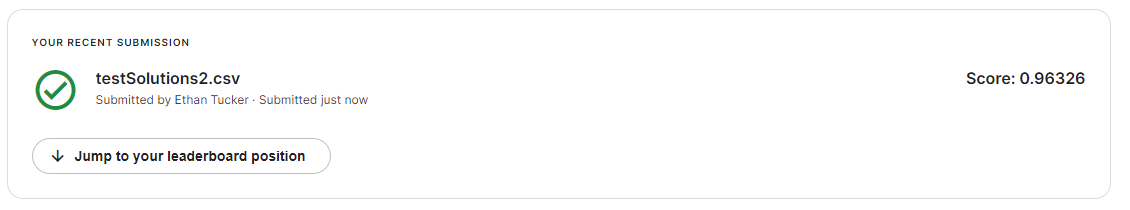

I doubt the IS solver will do much better, but here goes nothing.

#### IS-Loss:

In [263]:
# Make third model using IS-Loss
thirdModel = NMF(n_components = 5, random_state = 42, init = 'nndsvda', solver = "mu", beta_loss = "itakura-saito", max_iter= 1000)
W = thirdModel.fit_transform(response)
H = thirdModel.components_

ValueError: When beta_loss <= 0 and X contains zeros, the solver may diverge. Please add small values to X, or use a positive beta_loss.

### Commentary: 

The IS-Loss model did not work on our data, because the solver could diverge and sklearn didn't want to take that risk. Well, we tried. Here's a summary table as requested by the instructions:


| | L2     | KL     |
|-------------------|--------|--------|
| Train Accuracy    | 0.8819 | 0.9517 |
| Test Accuracy     | 0.8912 | 0.9632 |
| Average Recall    | 0.8768 | 0.9492 |
| Average Precision | 0.8898 | 0.9521 |

# Step 3: Compare with supervised learning [30 pts]

For my supervised learning approach, I will do a Binomial Regression (Multi-Class Logistic regression), where the features are the extracted feature weights using TF-IDF over all data before using labels. I will submit the results to kaggle to obtain accuracy measurements on the test set. Because we are limiting the training to less overall data that the unsupervised model, we are not guarenteed a better performance with respect to the unsupervised model. We could maximize performance by bagging the unsupervised and supervised approaches together. I will do as suggested in the instructions and plot Accuracy Vs. Number of Labels for the LogMod. I will put all the model performance screeshots after all the models are constructed, along with plots.

#### 10% of Labels:

In [ ]:
prop_labs = 0.10
test_start = traindf.to_numpy().shape[0]
n_train = math.floor(prop_labs * test_start)
Mod1TrainData = response[: n_train, :]
Mod1TestData = response[test_start:, :]

# Convert training labels to integers in accordance with labelDictionary
trainlabs = list(traindf["Category"])[:n_train]
numberlabs = list()
for lab in trainlabs:
    numberlabs.append(labelDictionary[lab])
numberlabs = np.asarray(numberlabs)

# Initialize binomial regression model with 10% labels, then predict labels on test set.
LogMod_10percent = LogisticRegression().fit(Mod1TrainData, numberlabs)
yhat = LogMod_10percent.predict(Mod1TestData)

# Write predictions to csv to send to kaggle
newpred = list()
for pred in yhat:
    this_category = makeNames[pred]
    newpred.append(this_category)
    
testDic = {
    "ArticleId" : list(testdf["ArticleId"]),
    "Category" : newpred
}

first_supervisedSolutiondf = pd.DataFrame(testDic)
first_supervisedSolutiondf.to_csv("./testSolutions3.csv")

#### 25% of labels:

In [ ]:
prop_labs = 0.25
test_start = traindf.to_numpy().shape[0]
n_train = math.floor(prop_labs * test_start)
Mod2TrainData = response[: n_train, :]
Mod2TestData = response[test_start:, :]

# Convert training labels to integers in accordance with labelDictionary
trainlabs = list(traindf["Category"])[:n_train]
numberlabs = list()
for lab in trainlabs:
    numberlabs.append(labelDictionary[lab])
numberlabs = np.asarray(numberlabs)

# Initialize binomial regression model with 10% labels, then predict labels on test set.
LogMod_25percent = LogisticRegression().fit(Mod2TrainData, numberlabs)
yhat = LogMod_25percent.predict(Mod2TestData)

# Write predictions to csv to send to kaggle
newpred = list()
for pred in yhat:
    this_category = makeNames[pred]
    newpred.append(this_category)
    
testDic = {
    "ArticleId" : list(testdf["ArticleId"]),
    "Category" : newpred
}

second_supervisedSolutiondf = pd.DataFrame(testDic)
second_supervisedSolutiondf.to_csv("./testSolutions4.csv")

#### 50% of labels:

In [ ]:
prop_labs = 0.50
test_start = traindf.to_numpy().shape[0]
n_train = math.floor(prop_labs * test_start)
Mod3TrainData = response[: n_train, :]
Mod3TestData = response[test_start:, :]

# Convert training labels to integers in accordance with labelDictionary
trainlabs = list(traindf["Category"])[:n_train]
numberlabs = list()
for lab in trainlabs:
    numberlabs.append(labelDictionary[lab])
numberlabs = np.asarray(numberlabs)

# Initialize binomial regression model with 10% labels, then predict labels on test set.
LogMod_50percent = LogisticRegression().fit(Mod3TrainData, numberlabs)
yhat = LogMod_50percent.predict(Mod3TestData)

# Write predictions to csv to send to kaggle
newpred = list()
for pred in yhat:
    this_category = makeNames[pred]
    newpred.append(this_category)
    
testDic = {
    "ArticleId" : list(testdf["ArticleId"]),
    "Category" : newpred
}

third_supervisedSolutiondf = pd.DataFrame(testDic)
third_supervisedSolutiondf.to_csv("./testSolutions5.csv")

#### 75% of labels:

In [ ]:
prop_labs = 0.75
test_start = traindf.to_numpy().shape[0]
n_train = math.floor(prop_labs * test_start)
Mod4TrainData = response[: n_train, :]
Mod4TestData = response[test_start:, :]

# Convert training labels to integers in accordance with labelDictionary
trainlabs = list(traindf["Category"])[:n_train]
numberlabs = list()
for lab in trainlabs:
    numberlabs.append(labelDictionary[lab])
numberlabs = np.asarray(numberlabs)

# Initialize binomial regression model with 10% labels, then predict labels on test set.
LogMod_75percent = LogisticRegression().fit(Mod4TrainData, numberlabs)
yhat = LogMod_75percent.predict(Mod4TestData)

# Write predictions to csv to send to kaggle
newpred = list()
for pred in yhat:
    this_category = makeNames[pred]
    newpred.append(this_category)
    
testDic = {
    "ArticleId" : list(testdf["ArticleId"]),
    "Category" : newpred
}

fourth_supervisedSolutiondf = pd.DataFrame(testDic)
fourth_supervisedSolutiondf.to_csv("./testSolutions6.csv")

#### 100% of labels:

In [ ]:
prop_labs = 1
test_start = traindf.to_numpy().shape[0]
n_train = math.floor(prop_labs * test_start)
Mod5TrainData = response[: n_train, :]
Mod5TestData = response[test_start:, :]

# Convert training labels to integers in accordance with labelDictionary
trainlabs = list(traindf["Category"])[:n_train]
numberlabs = list()
for lab in trainlabs:
    numberlabs.append(labelDictionary[lab])
numberlabs = np.asarray(numberlabs)

# Initialize binomial regression model with 10% labels, then predict labels on test set.
LogMod_100percent = LogisticRegression().fit(Mod5TrainData, numberlabs)
yhat = LogMod_100percent.predict(Mod5TestData)

# Write predictions to csv to send to kaggle
newpred = list()
for pred in yhat:
    this_category = makeNames[pred]
    newpred.append(this_category)
    
testDic = {
    "ArticleId" : list(testdf["ArticleId"]),
    "Category" : newpred
}

fifth_supervisedSolutiondf = pd.DataFrame(testDic)
fifth_supervisedSolutiondf.to_csv("./testSolutions7.csv")

### Supervised Learning Results:

#### 10% of labels:

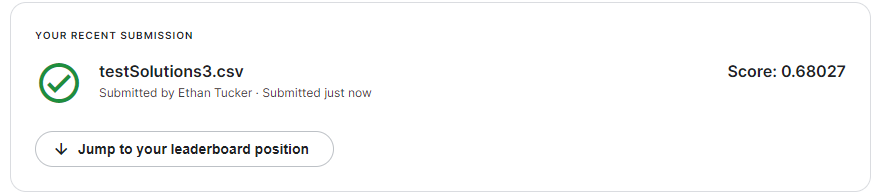

#### 25% of labels:

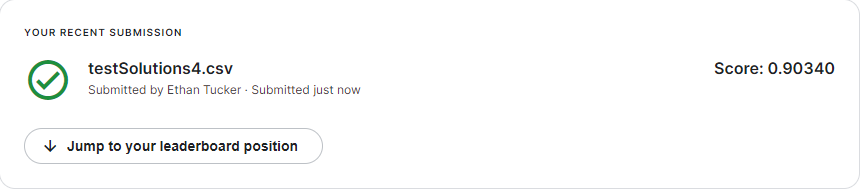

#### 50% of labels:

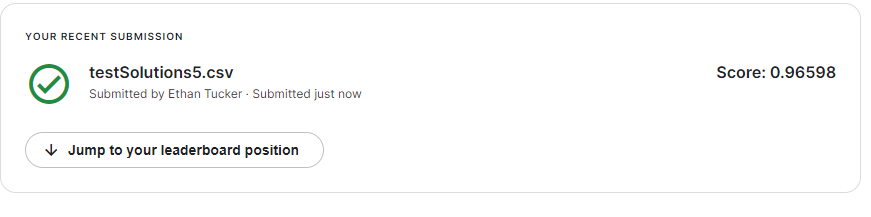

#### 75% of labels:

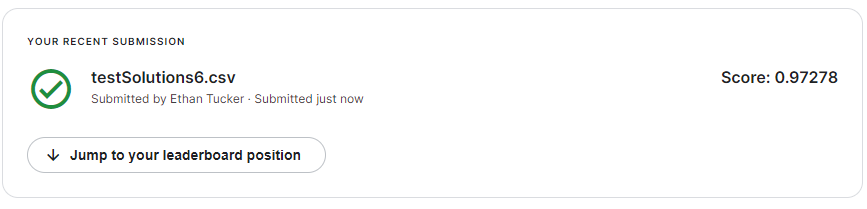

#### 100% of labels:

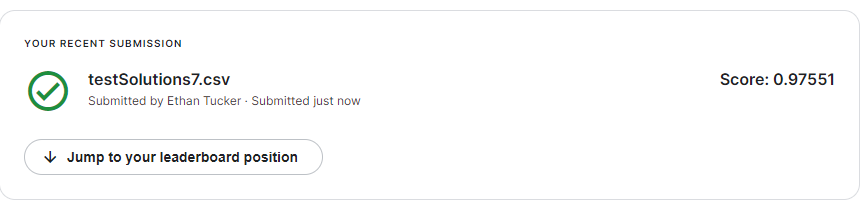

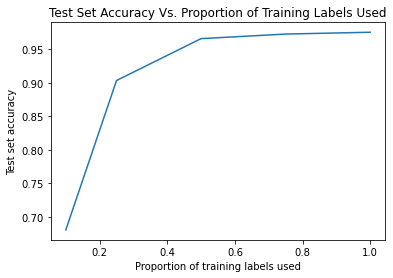

In [265]:
props = [0.1, 0.25, 0.5, 0.75, 1]
acc = [0.68027, 0.9034, 0.96598, 0.97278, 0.97551]

plt.plot(props, acc)
plt.xlabel("Proportion of training labels used")
plt.ylabel("Test set accuracy")
plt.title("Test Set Accuracy Vs. Proportion of Training Labels Used")
plt.show()

### Commentary:

The model stopped getting better around 50 ~ 75 % of training labels. One major concern is that TF-IDF is calculated over all data - training and test - and so there is some concern of overfitting due to correlation between the train and test sets. That said, constructin the TF-IDF matrix without labels helps to mitigate this risk. The LogReg ran quite a lot faster than the unsupervised models because it did not have to factor a large sparse matrix. To maximize accuracy, I would choose the supervised model. The true power of the unsupervised model is the ability to construct an arbitrary number of categories, which humans would not have imagined before construction. Even though we know there are five "real" categories, there may be any number of subtopics that exist within the data. A great follow up project would be to iterate over the number of categories and try to find spikes in test prediction accuracy. This would correspond to the discovery of true subtopics. More work would then be required (i.e. actually reading the articles) to determine what those subtopics are.

# Bibliography

1) [FreeCodeCamp on TF-IDF for text processing](https://www.freecodecamp.org/news/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3/)

2) [Medium blog post on TF-IDF for text processing](https://medium.com/@imamun/creating-a-tf-idf-in-python-e43f05e4d424)

3) [Numpy conversion from float to int](https://www.datasciencelearner.com/convert-numpy-float-to-int/)